In [1]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from helpers import load_fixeddepth_summary


OUT_DIR = "../paper_figures/"
os.makedirs(OUT_DIR, exist_ok=True)

# import matplotlib as mpl
# mpl.rcParams.update({"font.family": "DejaVu Sans"})

# small helper for panel letters
def add_panel_letter(ax, letter):
    ax.text(-0.08, 1.08, letter, transform=ax.transAxes, fontsize=12,
            fontweight="bold", va="top", ha="left")

# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}

# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2],
        fixed_frac      = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False, True],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# --- small helpers ------------------------------------------------------------
def add_panel_letter(ax, letter):
    ax.text(-0.08, 1.02, letter, transform=ax.transAxes,
            fontsize=12, fontweight="bold", va="bottom", ha="left")


# --- Helper: gemeinsamer Norm/Cmap über alle DFs ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

def build_lambda_norm(dfs, cmap_name="plasma"):
    all_lams = np.concatenate([
        df[df.variant != "without"]["drop_strength"].unique() for df in dfs
    ])
    vmin, vmax = float(np.nanmin(all_lams)), float(np.nanmax(all_lams))
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    return norm, cmap



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

def plot_peak_efficiency_vs_phi_panel(
    df, cache, ax=None, *,
    norm=None, cmap=None, add_cbar=False,
    axis_fs=10, tick_fs=9, rotate=15,
    add_baseline_legend=False, show_ylabel=True
):
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(2.6, 2.1), dpi=150)
        created_fig = True
    else:
        fig = ax.figure

    inter_all = df[df.variant != "without"].dropna(subset=["fixed_frac", "drop_strength"])
    ibl_rows  = inter_all[inter_all.intervention_baseline]
    inter     = inter_all[~inter_all.intervention_baseline]
    if inter.empty:
        return fig, ax

    phis = sorted(inter.fixed_frac.unique())
    lams = sorted(inter.drop_strength.unique())

    # Baseline-Peak (Zeitindex & Wert) aus den "without"-Runs
    pop = df.loc[df.variant == "without", "pop"].iat[0]
    base_time_idx, base_time_val = {}, {}
    for key, summ in cache.items():
        if key[0] != "without":
            continue
        lam = key[2]    # drop_strength
        tnf = key[5]    # top_node_frac
        inf_series = np.asarray(summ["infected_mean"]) / pop * 100.0
        idx = int(np.argmax(inf_series))
        base_time_idx[(lam, tnf)] = idx
        base_time_val[(lam, tnf)] = float(inf_series[idx])
    base_time_idx_ds = {lam: idx for (lam, _), idx in base_time_idx.items()}
    base_time_val_ds = {lam: val for (lam, _), val in base_time_val.items()}

    if cmap is None or norm is None:
        cmap = plt.get_cmap("plasma")
        norm = mcolors.Normalize(vmin=min(lams), vmax=max(lams))
    if add_cbar:
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = ax.figure.colorbar(sm, ax=ax, pad=0.02, fraction=0.05, aspect=30)
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    # Hauptlinien + SD (wie gehabt)
    all_means = []
    for lam in lams:
        y_line = [inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]["peak_efficiency"].mean()
                  for phi in phis]
        sds = []
        for phi in phis:
            sel = inter[(inter.drop_strength==lam) & (inter.fixed_frac==phi)]
            if sel.empty:
                sds.append(np.nan); continue
            row  = sel.iloc[0]; summ = cache[row["_key"]]
            tnf  = row.get("top_node_frac", None)
            idx  = base_time_idx.get((lam, tnf), base_time_idx_ds.get(lam))
            bvl  = base_time_val.get((lam, tnf), base_time_val_ds.get(lam))
            if (idx is None) or (bvl in (None, 0)):
                sds.append(np.nan); continue
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            inf_at_idx = np.asarray(summ["infected_ts"][:, idx], float) / pop * 100.0
            red_runs   = 100.0 * (bvl - inf_at_idx) / bvl
            eff_runs   = np.where(mask, red_runs / eruns, np.nan)
            sds.append(np.nanstd(eff_runs, ddof=1))

        ax.plot(phis, y_line, '-', marker='o', markersize=5, linewidth=1.8, color=cmap(norm(lam)))
        m, s = np.array(y_line, float), np.array(sds, float)
        ax.fill_between(phis, m - s, m + s, alpha=0.06, color=cmap(norm(lam)))
        all_means.extend(y_line)

    # ── Baseline (no-threshold) mit SD-Schattierung ────────────────────────────
    baseline_vals = []
    if not ibl_rows.empty:
        lam0 = sorted(ibl_rows.drop_strength.unique())[0]
        sel0 = ibl_rows[ibl_rows.drop_strength == lam0]
        phi_vals = sorted(sel0.fixed_frac.unique())
        y_vals   = [sel0[sel0.fixed_frac == φ]["peak_efficiency"].mean() for φ in phi_vals]

        # SD der Baseline:
        s_base = []
        for φ in phi_vals:
            row = sel0[sel0.fixed_frac == φ].iloc[0]
            summ = cache[row["_key"]]
            tnf  = row.get("top_node_frac", None)
            idx  = base_time_idx.get((lam0, tnf), base_time_idx_ds.get(lam0))
            bvl  = base_time_val.get((lam0, tnf), base_time_val_ds.get(lam0))
            if (idx is None) or (bvl in (None, 0)):
                s_base.append(np.nan); continue
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            inf_at_idx = np.asarray(summ["infected_ts"][:, idx], float) / pop * 100.0
            red_runs   = 100.0 * (bvl - inf_at_idx) / bvl
            eff_runs   = np.where(mask, red_runs / eruns, np.nan)
            s_base.append(np.nanstd(eff_runs, ddof=1))

        # Plot
        ax.plot(phi_vals, y_vals, '--', lw=1.0, color='grey', alpha=0.9,
                label="no threshold" if add_baseline_legend else None)
        ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
        s_base = np.array(s_base, float)
        ax.fill_between(phi_vals, np.array(y_vals)-s_base, np.array(y_vals)+s_base,
                        color='grey', alpha=0.06, zorder=0)
        baseline_vals.extend(y_vals)

    # y-Limits
    vals = all_means + baseline_vals
    if vals and not np.all(np.isnan(vals)):
        ymin, ymax = np.nanmin(vals), np.nanmax(vals)
        ax.set_ylim(bottom=max(0, ymin*0.95), top=ymax*1.05 if ymax > 0 else 1.0)

    if show_ylabel:
        ax.set_ylabel(r"Peak-efficiency ratio $\mathcal{E}_{\mathrm{peak}}$", fontsize=axis_fs, labelpad=2)
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"Removal fraction $\phi$", fontsize=axis_fs, labelpad=2)
    xticks = [0.1, 0.3, 0.5, 0.75, 1.0]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{φ:.2f}" for φ in xticks], fontsize=tick_fs)
    for t in ax.get_xticklabels():
        t.set_rotation(rotate); t.set_ha('center'); t.set_rotation_mode('anchor')
    ax.tick_params(axis='y', labelsize=tick_fs)
    ax.grid(linestyle=':', alpha=0.5)
    ax.margins(x=0.03, y=0.05)
    if add_baseline_legend:
        ax.legend(frameon=False, fontsize=axis_fs-2, loc='upper right')

    if created_fig:
        fig.tight_layout()
    return fig, ax

def plot_attack_efficiency_vs_phi_panel(
    df, cache, ax=None, *,
    norm=None, cmap=None, add_cbar=False,
    axis_fs=10, tick_fs=9, rotate=15,
    add_baseline_legend=False, show_ylabel=True
):
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(2.6, 2.1), dpi=150)
        created_fig = True
    else:
        fig = ax.figure

    inter_all = df[df.variant != "without"].dropna(subset=["fixed_frac","drop_strength"])
    ibl_rows  = inter_all[inter_all.intervention_baseline]
    inter     = inter_all[~inter_all.intervention_baseline]
    if inter.empty:
        return fig, ax

    phis = sorted(inter.fixed_frac.unique())
    lams = sorted(inter.drop_strength.unique())
    base_inf_mean = df.loc[df.variant == "without", "finf_abs"].mean()

    if cmap is None or norm is None:
        cmap = plt.get_cmap("plasma")
        norm = mcolors.Normalize(vmin=min(lams), vmax=max(lams))
    if add_cbar:
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = ax.figure.colorbar(sm, ax=ax, pad=0.02, fraction=0.05, aspect=30)
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    all_means = []
    for lam in lams:
        y_line = [inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]["efficiency"].mean()
                  for phi in phis]
        sds = []
        for phi in phis:
            sel = inter[(inter.drop_strength==lam)&(inter.fixed_frac==phi)]
            if sel.empty:
                sds.append(np.nan); continue
            row = sel.iloc[0]; summ = cache[row["_key"]]
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            finfr = np.asarray(summ["final_infected_abs_runs"], float)
            eff_runs = np.where(mask, 100.0*(base_inf_mean - finfr)/base_inf_mean / eruns, np.nan)
            sds.append(np.nanstd(eff_runs, ddof=1))

        ax.plot(phis, y_line, '-', marker='o', markersize=5, linewidth=1.8, color=cmap(norm(lam)))
        m, s = np.array(y_line, float), np.array(sds, float)
        ax.fill_between(phis, m - s, m + s, alpha=0.06, color=cmap(norm(lam)))
        all_means.extend(y_line)

    # ── Baseline (no-threshold) mit SD ─────────────────────────────────────────
    baseline_vals = []
    if not ibl_rows.empty:
        lam0 = sorted(ibl_rows.drop_strength.unique())[0]
        sel0 = ibl_rows[ibl_rows.drop_strength == lam0]
        phi_vals = sorted(sel0.fixed_frac.unique())
        y_vals   = [sel0[sel0.fixed_frac == φ]["efficiency"].mean() for φ in phi_vals]

        s_base = []
        for φ in phi_vals:
            row = sel0[sel0.fixed_frac == φ].iloc[0]
            summ = cache[row["_key"]]
            eruns = np.asarray(summ["edges_removed_pct_runs"], float)
            mask  = eruns > 0.05
            finfr = np.asarray(summ["final_infected_abs_runs"], float)
            eff_runs = np.where(mask, 100.0*(base_inf_mean - finfr)/base_inf_mean / eruns, np.nan)
            s_base.append(np.nanstd(eff_runs, ddof=1))

        ax.plot(phi_vals, y_vals, '--', lw=1.0, color='grey', alpha=0.9,
                label="no threshold" if add_baseline_legend else None)
        ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
        s_base = np.array(s_base, float)
        ax.fill_between(phi_vals, np.array(y_vals)-s_base, np.array(y_vals)+s_base,
                        color='grey', alpha=0.06, zorder=0)
        baseline_vals.extend(y_vals)

    vals = all_means + baseline_vals
    if vals and not np.all(np.isnan(vals)):
        ymin, ymax = np.nanmin(vals), np.nanmax(vals)
        ax.set_ylim(bottom=max(0, ymin*0.95), top=ymax*1.05 if ymax > 0 else 1.0)

    if show_ylabel:
        ax.set_ylabel(r"Attack-rate efficiency $\mathcal{E}_{\mathrm{AR}}$", fontsize=axis_fs, labelpad=2)
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"Removal fraction $\phi$", fontsize=axis_fs, labelpad=2)
    xticks = [0.1, 0.3, 0.5, 0.75, 1.0]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{φ:.2f}" for φ in xticks], fontsize=tick_fs)
    for t in ax.get_xticklabels():
        t.set_rotation(rotate); t.set_ha('center'); t.set_rotation_mode('anchor')
    ax.tick_params(axis='y', labelsize=tick_fs)
    ax.grid(linestyle=':', alpha=0.5)
    ax.margins(x=0.03, y=0.05)
    if add_baseline_legend:
        ax.legend(frameon=False, fontsize=axis_fs-2, loc='upper right')

    if created_fig:
        fig.tight_layout()
    return fig, ax


In [3]:

# --- load datasets ------------------------------------------------------------

df_abm,   cache_abm   = load_dataset("abm")
df_dtu,   cache_dtu   = load_dataset("DTU")
df_office,cache_office= load_dataset("workplace")

Loading abm …
Loading 7 baseline + 0 risk-depth + 112 fixed-depth files


✓ results_without_ii24_ds110_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (1/119)
✓ results_without_ii24_ds150_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (2/119)
✓ results_dynThresh_FRem_ii24_ds130_mrfNA_frem10_tnfNA_ibl1_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (3/119)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem20_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (4/119)
✓ results_without_ii24_ds90_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (5/119)
✓ results_without_ii24_ds130_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (6/119)
✓ results_dynThresh_FRem_ii24_ds110_mrfNA_frem10_tn

/tmp/ipykernel_2414152/2276538721.py:108: UserWarning: You passed a edgecolor/edgecolors ('grey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
/tmp/ipykernel_2414152/2276538721.py:108: UserWarning: You passed a edgecolor/edgecolors ('grey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(phi_vals, y_vals, facecolors='none', edgecolors='grey', marker='x', s=25, lw=0.9)
/tmp/ipykernel_2414152/2276538721.py:72: RuntimeWarning: divide by zero encountered in divide
  eff_runs   = np.where(mask, red_runs / eruns, np.nan)
/tmp/ipykernel_2414152/2276538721.py:108: UserWarning: You passed a edgecolor/edgecolors ('grey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.

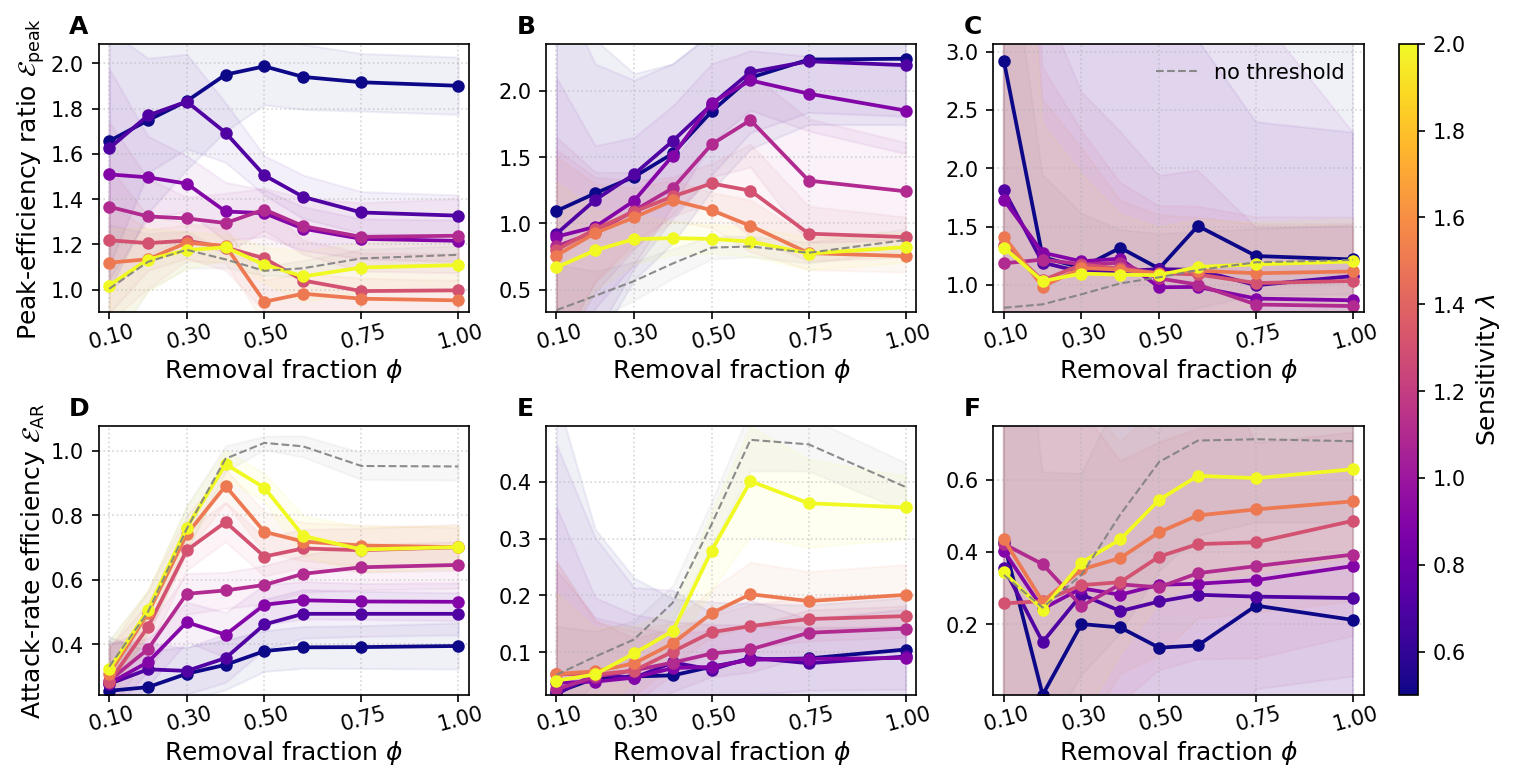

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5.1), dpi=150, constrained_layout=True)
axs = axes.ravel()

# gemeinsames Norm/Cmap für λ
norm, cmap = build_lambda_norm([df_abm, df_dtu, df_office], cmap_name="plasma")

plot_peak_efficiency_vs_phi_panel(df_abm,    cache_abm,    ax=axs[0], norm=norm, cmap=cmap, add_cbar=False, axis_fs=12, tick_fs=10, show_ylabel=True)
plot_peak_efficiency_vs_phi_panel(df_dtu,    cache_dtu,    ax=axs[1], norm=norm, cmap=cmap, add_cbar=False, axis_fs=12, tick_fs=10, show_ylabel=False)
plot_peak_efficiency_vs_phi_panel(df_office, cache_office, ax=axs[2], norm=norm, cmap=cmap, add_cbar=False, axis_fs=12, tick_fs=10, show_ylabel=False, add_baseline_legend=True)

plot_attack_efficiency_vs_phi_panel(df_abm,    cache_abm,    ax=axs[3], norm=norm, cmap=cmap, add_cbar=False, axis_fs=12, tick_fs=10, show_ylabel=True)
plot_attack_efficiency_vs_phi_panel(df_dtu,    cache_dtu,    ax=axs[4], norm=norm, cmap=cmap, add_cbar=False, axis_fs=12, tick_fs=10, show_ylabel=False)
plot_attack_efficiency_vs_phi_panel(df_office, cache_office, ax=axs[5], norm=norm, cmap=cmap, add_cbar=False, axis_fs=12, tick_fs=10, show_ylabel=False)

# gemeinsame Colorbar rechts
sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, location="right", fraction=0.035, pad=0.015, aspect=35)
cbar.set_label(r"Sensitivity $\lambda$", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Panel-Buchstaben
for ax, letter in zip(axs, list("ABCDEF")):
    add_panel_letter(ax, letter)

# PLOS: als 600-dpi TIFF speichern
fig.savefig(OUT_DIR + "Fig4.tif", dpi=600, format="tiff",
            pil_kwargs={"compression": "tiff_lzw"},
            bbox_inches="tight")


In [5]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from helpers import load_fixeddepth_summary

# import matplotlib as mpl
# mpl.rcParams.update({"font.family": "DejaVu Sans"})


# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}

# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.7],
        fixed_frac      = [0.1, 0.2, 0.25, 0.5, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False, True],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache


# --- small helpers ------------------------------------------------------------
def add_panel_letter(ax, letter):
    ax.text(-0.0, 1.02, letter, transform=ax.transAxes,
            fontsize=12, fontweight="bold", va="bottom", ha="left")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

def build_lambda_norm(dfs, cmap_name="plasma"):
    all_lams = np.concatenate([
        df[df.variant != "without"]["drop_strength"].unique() for df in dfs
    ])
    vmin, vmax = float(np.nanmin(all_lams)), float(np.nanmax(all_lams))
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    return norm, cmap



In [6]:
def load_dataset_with_compliance(network_name, compliance_list):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)

    filters = make_filters(network_name)
    filters["compliance"] = list(compliance_list)   

    print(f"Loading {network_name} (compliance={filters['compliance']}) …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache

def _baseline_maps_for_peak(
    df,
    cache,
):
    """
    Map baseline peak time index and value for (drop_strength λ, top_node_frac tnf),
    plus per-λ fallbacks. Needed to compute per-run peak reduction SD.
    """
    import numpy as np

    pop = df.loc[df.variant == "without", "pop"].iat[0]
    base_time_idx, base_time_val = {}, {}
    for key, summ in cache.items():
        if key[0] != "without":
            continue
        lam = key[2]     # drop_strength λ
        tnf = key[5]     # top_node_frac
        inf_series = np.asarray(summ["infected_mean"]) / pop * 100.0
        idx = int(np.argmax(inf_series))
        base_time_idx[(lam, tnf)] = idx
        base_time_val[(lam, tnf)] = float(inf_series[idx])

    base_time_idx_ds = {lam: idx for (lam, _), idx in base_time_idx.items()}
    base_time_val_ds = {lam: val for (lam, _), val in base_time_val.items()}
    return pop, base_time_idx, base_time_val, base_time_idx_ds, base_time_val_ds

def _phi_color_map(
    phis_present,
    cmap_name="tab10",
):
    """
    Build a stable color map for φ in [0.10, 0.25, 0.50, 1.00] using tab10.
    Only returns colours for values that are present.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    target = [0.10, 0.25, 0.50, 1.00]
    target = [p for p in target if p in phis_present]
    cmap   = plt.get_cmap(cmap_name)
    cols   = cmap(np.linspace(0, 1, max(4, len(target))))[:len(target)]
    return dict(zip(target, cols))



In [7]:
def plot_compliance_vs_peak_reduction_lam(
    df, cache, lam=0.7, ax=None, *,
    axis_fs=12, tick_fs=10, rotate=0,
    add_legend=False, legend_loc="upper left",
    ytick_step=None, ylim=None
):
    """
    Compliance c (x) vs. peak infection reduction [%] (y).
    Lines are φ in {0.10, 0.25, 0.50, 1.00}.
    λ is fixed (default 0.7). Line = df mean 'peak_reduced_pct' per c.
    Shading = SD across runs of % peak reduction at the baseline peak time.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # filter to true interventions and λ≈lam
    inter = df[(df.variant != "without") & (~df.intervention_baseline)].copy()
    inter = inter[np.isfinite(inter.get("peak_reduced_pct", np.nan))]
    inter = inter[np.isclose(inter["drop_strength"].values, lam, atol=1e-9)]

    if inter.empty:
        return (ax.figure if ax is not None else None), ax

    # φ lines we want; keep only those present
    wanted_phis = [0.10, 0.25, 0.50, 1.00]
    phis = [p for p in wanted_phis if p in set(inter.fixed_frac.unique())]
    if not phis:
        return (ax.figure if ax is not None else None), ax

    # stable φ colors
    phi_colors = _phi_color_map(phis)

    # baseline peak maps (λ, tnf) → index/value
    pop, base_idx, base_val, base_idx_ds, base_val_ds = _baseline_maps_for_peak(df, cache)

    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.6, 3.0), dpi=150)
        created = True
    else:
        fig = ax.figure

    all_y = []

    for phi in phis:
        sub = inter[inter.fixed_frac == phi].copy()
        if sub.empty:
            continue

        # line: mean across rows (seeds/realizations) at each c for this φ, λ
        line_df = (sub.groupby("compliance", as_index=False)["peak_reduced_pct"]
                     .mean()
                     .sort_values("compliance"))
        x_line = line_df["compliance"].to_numpy(float)
        y_line = line_df["peak_reduced_pct"].to_numpy(float)

        # shading: SD across runs at baseline peak for the same rows
        sd_map = {}
        for c_val, rows in sub.groupby("compliance"):
            perrun_list = []
            for _, row in rows.iterrows():
                summ = cache[row["_key"]]
                tnf  = row.get("top_node_frac", None)
                idx  = base_idx.get((lam, tnf), base_idx_ds.get(lam))
                bvl  = base_val.get((lam, tnf), base_val_ds.get(lam))
                if (idx is None) or (bvl in (None, 0)):
                    continue
                inf_at_idx = np.asarray(summ["infected_ts"][:, idx], float) / pop * 100.0
                red_runs   = 100.0 * (bvl - inf_at_idx) / bvl
                perrun_list.append(red_runs)
            if perrun_list:
                sd_map[float(c_val)] = np.nanstd(np.concatenate(perrun_list), ddof=1)

        col = phi_colors[phi]
        ax.plot(x_line, y_line, "-o", lw=1.8, ms=6, color=col, label=fr"$\phi={phi:.2f}$")
        if sd_map:
            s = np.array([sd_map.get(x, np.nan) for x in x_line], float)
            ax.fill_between(x_line, y_line - s, y_line + s, color=col, alpha=0.10)

        all_y.extend(y_line.tolist())

    # labels/ticks/grid
    ax.set_xlabel(r"Compliance $c$", fontsize=axis_fs)
    ax.set_ylabel("Peak infection\nreduction [%]", fontsize=axis_fs)
    ax.set_xticks(sorted(inter.compliance.unique()))
    for t in ax.get_xticklabels():
        t.set_rotation(rotate); t.set_ha("center"); t.set_rotation_mode("anchor")
    ax.tick_params(labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.5)

    # y-lims & optional y-tick step
    if ylim is not None:
        ax.set_ylim(*ylim)
    elif all_y:
        ymin, ymax = np.nanmin(all_y), np.nanmax(all_y)
        ax.set_ylim(bottom=max(0, 0.95*ymin), top=(1.05*ymax if ymax > 0 else 1.0))

    if ytick_step is not None:
        import math, numpy as np
        y0, y1 = ax.get_ylim()
        start = ytick_step * math.floor(y0 / ytick_step)
        stop  = ytick_step * math.ceil(y1 / ytick_step)
        ax.set_yticks(np.arange(start, stop + 0.1*ytick_step, ytick_step))

    if add_legend:
        ax.legend(frameon=False, fontsize=axis_fs-2, loc=legend_loc,
                   title_fontsize=axis_fs-2)

    if created:
        fig.tight_layout()
    return fig, ax


In [8]:
# ▸ unbedingt mit mehreren c-Werten laden
COMPLIANCE = [0.3, 0.6, 0.9, 1.0]

df_abm_c,    cache_abm_c    = load_dataset_with_compliance("abm",       COMPLIANCE)
df_dtu_c,    cache_dtu_c    = load_dataset_with_compliance("DTU",       COMPLIANCE)
df_office_c, cache_office_c = load_dataset_with_compliance("workplace", COMPLIANCE)


Loading abm (compliance=[0.3, 0.6, 0.9, 1.0]) …
Loading 1 baseline + 0 risk-depth + 10 fixed-depth files


✓ results_dynThresh_FRem_ii24_ds70_mrfNA_frem10_tnfNA_ibl1_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (1/11)
✓ results_dynThresh_FRem_ii24_ds70_mrfNA_frem100_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (2/11)
✓ results_dynThresh_FRem_ii24_ds70_mrfNA_frem100_tnfNA_ibl1_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (3/11)
✓ results_without_ii24_ds70_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (4/11)
✓ results_dynThresh_FRem_ii24_ds70_mrfNA_frem10_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (5/11)
✓ results_dynThresh_FRem_ii24_ds70_mrfNA_frem20_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (6/11)
✓ results_dynThresh_FRem_ii24_ds70_mrfNA_frem50_tnfNA_ibl0_c100_ft

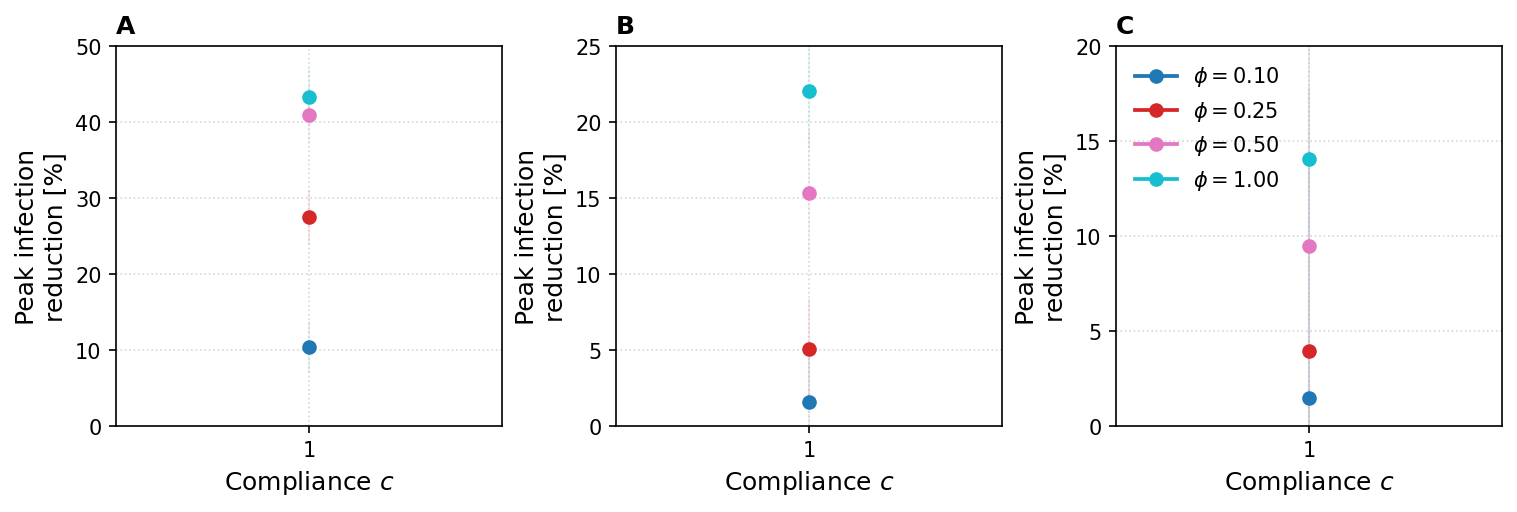

In [9]:
# You need to run the main.py experiments with compliance values
# COMPLIANCE = [0.3, 0.6, 0.9, 1.0] to get these plots.

fig, axes = plt.subplots(1, 3, figsize=(10, 3.3), dpi=150, constrained_layout=True)

# Use the datasets loaded with multiple compliance values
plot_compliance_vs_peak_reduction_lam(df_abm_c,    cache_abm_c,    lam=0.7, ax=axes[0], ytick_step=10)
plot_compliance_vs_peak_reduction_lam(df_dtu_c,    cache_dtu_c,    lam=0.7, ax=axes[1], ytick_step=5)
plot_compliance_vs_peak_reduction_lam(df_office_c, cache_office_c, lam=0.7, ax=axes[2],
                                      ytick_step=5, ylim=(0, 20), add_legend=True, legend_loc="upper left")

for ax, L in zip(axes, "ABC"):
    add_panel_letter(ax, L)

fig.savefig(OUT_DIR + "Fig6.tif",
            dpi=600, format="tiff",
            pil_kwargs={"compression":"tiff_lzw"},
            bbox_inches="tight")
